In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from os import pardir, path
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import glob
import seaborn as sns


%config InlineBackend.figure_format = 'retina'
sns.set_style("white")

In [ ]:
base = '/content/drive/MyDrive/Rooge_Project/'
base

'/content/drive/MyDrive/Rooge_Project/'

In [ ]:
df = pd.read_csv(base+'merge set 2and4.csv').T
df = df.rename(columns=df.iloc[0]).iloc[1:,:]

label_df = pd.read_csv(base+'Factors set2and4 (3 groups).csv').iloc[:,:3]
label_df['Type'] = label_df['Type'].str.replace(' ','')
# label_df['Class'] = label_df['Type']+'_'+label_df['Sample type']
label_df['Class'] = label_df['Type']
label_df = label_df.set_index('Sample Name')

rawData = pd.concat([df,label_df['Class']], axis=1).fillna(0)
rawData

,hsa-let-7a-2-3p,hsa-let-7a-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7b-5p,hsa-let-7c-3p,hsa-let-7c-5p,hsa-let-7d-3p,hsa-let-7d-5p,hsa-let-7e-3p,hsa-let-7e-5p,hsa-let-7f-1-3p,hsa-let-7f-2-3p,hsa-let-7f-5p,hsa-let-7g-3p,hsa-let-7g-5p,hsa-let-7i-3p,hsa-let-7i-5p,hsa-miR-1-3p,hsa-miR-1-5p,hsa-miR-100-3p,hsa-miR-100-5p,hsa-miR-101-2-5p,hsa-miR-101-3p,hsa-miR-101-5p,hsa-miR-10392-5p,hsa-miR-10394-3p,hsa-miR-10395-3p,hsa-miR-10395-5p,hsa-miR-10396a-3p,hsa-miR-10396a-5p,hsa-miR-10396b-3p,hsa-miR-10396b-5p,hsa-miR-10398-3p,hsa-miR-10398-5p,hsa-miR-10399-3p,hsa-miR-10399-5p,hsa-miR-103a-1-5p,hsa-miR-103a-2-5p,hsa-miR-103a-3p,...,hsa-miR-892b,hsa-miR-9-3p,hsa-miR-9-5p,hsa-miR-92a-1-5p,hsa-miR-92a-3p,hsa-miR-92b-3p,hsa-miR-92b-5p,hsa-miR-93-3p,hsa-miR-93-5p,hsa-miR-933,hsa-miR-934,hsa-miR-935,hsa-miR-937-3p,hsa-miR-937-5p,hsa-miR-938,hsa-miR-939-3p,hsa-miR-939-5p,hsa-miR-940,hsa-miR-941,hsa-miR-942-3p,hsa-miR-942-5p,hsa-miR-943,hsa-miR-944,hsa-miR-95-3p,hsa-miR-95-5p,hsa-miR-96-3p,hsa-miR-96-5p,hsa-miR-98-3p,hsa-miR-98-5p,hsa-miR-9898,hsa-miR-9901,hsa-miR-9902,hsa-miR-9903,hsa-miR-9985,hsa-miR-9986,hsa-miR-99a-3p,hsa-miR-99a-5p,hsa-miR-99b-3p,hsa-miR-99b-5p,Class
Sample Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
027A,22,925,3360476,1,1775940,49,717254,4065,173369,532,134015,124,76,889888,150,674389,386,513335,128,0,5,129622,0,395,4,2,0,65,0,0,0,0,0,8,5,64,12,9,83,18805,...,4,154,5298,213,106677,8392,332,137,59484,0,1,63,6,3,1,0,1,655,367,59,301,5,450,3453,1,15,6439,7,50791,0,1,1,1,64,0,3670,715291,2122,42490,HSIL
028A,26,1095,2406391,2,1182505,85,624916,3442,89432,496,82760,175,98,464699,87,624844,731,261460,60,0,0,103188,0,273,5,1,0,51,0,0,2,0,1,10,0,42,2,9,42,14261,...,0,104,5899,212,119429,3144,186,116,40235,1,0,46,7,10,0,3,3,1045,267,71,281,7,590,2723,0,3,3620,13,26833,0,0,2,0,145,1,3431,705733,1267,34820,HSIL
028B,26,1842,2367109,102,1,83,735019,2048,115075,411,66306,163,366,634090,107,560943,230,297822,295,0,6,150237,0,266,10,0,0,129,0,0,0,0,1,6,0,21,5,7,80,25850,...,0,163,7231,210,105745,1552,40,120,55216,0,0,32,0,3,0,1,2,600,204,57,276,3,933,2821,2,13,3396,6,29552,0,2,1,2,137,1,4097,951715,1084,25178,HSIL
029A,25,1653,3315951,77,2066454,53,1081770,1612,172283,515,109683,140,191,827690,116,725317,686,577829,1440,0,7,289643,0,231,9,0,0,77,0,0,1,0,0,14,0,42,9,8,15,16126,...,0,636,32285,479,130457,5530,237,81,54733,2,0,15,0,0,0,2,2,669,195,175,671,4,240,2389,3,16,4664,10,26404,0,3,5,1,433,7,3532,1329057,1108,46504,HSIL
031A,33,1372,1706596,37,1023669,169,939906,1008,79870,536,30348,96,104,476373,76,618933,457,381911,1102,0,12,324135,0,543,18,2,0,125,0,0,0,0,1,7,1,65,9,3,43,19461,...,0,276,12450,69,44810,3498,70,96,20469,0,0,46,2,0,0,0,0,141,330,20,185,3,7,788,0,3,2336,4,37289,1,9,1,3,140,0,4662,2706008,1151,72931,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DC053V,0,287,39253,0,32052,1,11088,185,5732,3,206,0,1,24414,39,23040,343,12690,41,0,0,360,0,271,0,0,0,4,0,0,0,0,0,0,0,1,2,6,49,187,...,0,18,29,5,22772,203,0,41,7147,1,47,1,3,0,1,1,0,42,97,17,30,0,622,1667,18,3,5318,0,2508,0,0,3,0,5,1,139,53757,9,687,HSIL
DC054E,0,183,3578,0,10808,0,559,173,614,8,73,0,0,2449,23,3781,289,11276,30,0,0,611,0,196,2,0,0,1,0,0,0,0,0,0,0,2,2,0,22,2,...,0,23,19,1,14498,105,0,41,6478,1,0,3,0,0,0,0,0,11,65,11,34,0,51,100,1,1,375,0,756,0,0,1,0,1,1,6,6172,20,335,HSIL
DC054V,1,130,3099,0,8564,1,1707,156,345,3,33,0,0,1545,11,1712,81,5310,207,0,0,416,0,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,...,0,12,22,0,7233,47,0,4,813,0,0,5,0,0,0,0,0,4,4,6,5,0,148,111,1,0,413,0,272,0,0,0,0,0,0,16,9214,6,169,HSIL


In [ ]:
# rawData.loc[:,pd.read_csv('Importance features.csv')['miRNA']].T.to_csv('Machine learning miRNA.csv')

In [ ]:
# data = rawData[(rawData['Class'] != 'AIS_Discharge') & (rawData['Class'] != 'HSIL_Discharge')]

In [ ]:
data = rawData
stat = pd.DataFrame(data.groupby(['Class']).agg(['count']).iloc[:,-1])
stat.columns = ['Count']
stat['Percentage'] = round(stat['Count']/stat['Count'].sum()*100,3)
stat

,Count,Percentage
Class,,
AIS,8,11.111
HSIL,59,81.944
Normal,5,6.944


In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


In [ ]:
# Normalized data
RS = preprocessing.RobustScaler()
scaled_df = pd.DataFrame(RS.fit_transform(data.iloc[:,:-1]) , columns= data.iloc[:,:-1].columns, index=data.index)
scaled_df['Target'] = data['Class']

In [ ]:
# Train and Test spliting with 0.67 and 0.33 respectively
X_train, X_test, y_train, y_test = train_test_split(scaled_df.iloc[:,:-1], scaled_df['Target'], 
                                                    test_size=0.33) # , random_state=7

Model_Name = 'RandomForestClassifier'
model=RandomForestClassifier() # step 1: choose model/estimator for classification
# model=LogisticRegression()
model.fit(X_train, y_train) # step 2: fit
y_pred=model.predict(X_test) # step 3: predict
print('Accuracy score:', model.score(X_test, y_test).round(3)) # step 4: accuracy score for classification r2 for regression
# classes=['AIS_Discharge', 'AIS_tissue','HSIL_Discharge','HSIL_tissue','Normal_tissue']
classes=list(set(data['Class']))
print(metrics.classification_report(y_test, y_pred, target_names=classes))
y_pred_prob = model.predict_proba(X_test)[::,1]

Accuracy score: 0.792
              precision    recall  f1-score   support

         AIS       0.00      0.00      0.00         4
        HSIL       0.79      1.00      0.88        19
      Normal       0.00      0.00      0.00         1

    accuracy                           0.79        24
   macro avg       0.26      0.33      0.29        24
weighted avg       0.63      0.79      0.70        24



In [ ]:
# show classification result
result = pd.concat([y_test.reset_index(),pd.DataFrame([y_pred,y_pred_prob]).T],axis=1)
result.columns = ['Patient','Class','Predicted','Predicted_Prob']
result

,Patient,Class,Predicted,Predicted_Prob
0,DC052V,HSIL,HSIL,0.93
1,041B,HSIL,HSIL,0.85
2,DC053C,HSIL,HSIL,0.68
3,052B,HSIL,HSIL,0.9
4,044A,Normal,HSIL,0.79
5,DC053V,HSIL,HSIL,0.81
6,038A,HSIL,HSIL,0.93
7,049C,AIS,HSIL,0.77
8,043D,HSIL,HSIL,0.69
9,046B,HSIL,HSIL,0.73


![image.png](attachment:image.png)

In [ ]:
# Train Test spliting and 10 fold Cross validation

print('Performance of classification model before feature selection')
scaled_df = pd.DataFrame(RS.fit_transform(data.iloc[:,:-1]) , columns= data.iloc[:,:-1].columns, index=data.index)
scaled_df['Target'] = data['Class']

cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
X=scaled_df.iloc[:,:-1]
print('Number of all features ', X.shape)
y=scaled_df['Target']
scores = cross_val_score(model, X,y, scoring='accuracy',cv=cv,n_jobs=-1)
print('Accuracy: %.3f (%.3f)'% (np.mean(scores),np.std(scores)))


# Feature selection by using Random Forest
importance = model.feature_importances_
importance_score = pd.DataFrame([X.columns, importance]).T
importance_score.columns = ['miRNA','Score']
importance_score = importance_score.sort_values(by='Score', ascending=False)
miRNA1 = importance_score[importance_score['Score'] > 0]['miRNA']

print("\n",'*'*30)
print('Performance of classification model after feature selection')
cv = StratifiedKFold(n_splits=10, random_state=123, shuffle=True)
X=scaled_df.loc[:,miRNA1]
print('Number of Selected features ', X.shape)
y=scaled_df['Target']
scores = cross_val_score(model, X,y, scoring='accuracy',cv=cv,n_jobs=-1)
print('Accuracy: %.3f (%.3f)'% (np.mean(scores),np.std(scores)))

Performance of classification model before feature selection
Number of all features  (72, 1731)
Accuracy: 0.821 (0.055)

 ******************************
Performance of classification model after feature selection
Number of Selected features  (72, 379)
Accuracy: 0.821 (0.055)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df.iloc[:,:-1], scaled_df['Target'], 
                                                    test_size=0.33)
y_pred=model.predict(X_test) # step 3: predict
print('Accuracy score:', model.score(X_test, y_test).round(3)) # step 4: accuracy score for classification r2 for regression
# classes=['AIS_Discharge', 'AIS_tissue','HSIL_Discharge','HSIL_tissue','Normal_tissue']
classes=list(set(data['Class']))
print(metrics.classification_report(y_test, y_pred, target_names=classes))
# print('-' * 100)

y_pred_prob = model.predict_proba(X_test)[::,1]

result = pd.concat([y_test.reset_index(),pd.DataFrame([y_pred,y_pred_prob]).T],axis=1)
result.columns = ['Patient','Class','Predicted','Predicted_Prob']
result

Accuracy score: 0.917
              precision    recall  f1-score   support

         AIS       1.00      0.67      0.80         3
        HSIL       0.90      1.00      0.95        19
      Normal       1.00      0.50      0.67         2

    accuracy                           0.92        24
   macro avg       0.97      0.72      0.81        24
weighted avg       0.92      0.92      0.91        24



,Patient,Class,Predicted,Predicted_Prob
0,040A,HSIL,HSIL,0.95
1,036A,HSIL,HSIL,0.96
2,DC049V,AIS,AIS,0.28
3,044B,Normal,Normal,0.35
4,047B,HSIL,HSIL,0.97
5,DC055E,HSIL,HSIL,0.86
6,049A,AIS,AIS,0.17
7,029A,HSIL,HSIL,0.92
8,044A,Normal,HSIL,0.79
9,DC052C,HSIL,HSIL,0.94


In [ ]:
# 3 times Upsampling on AIS and Normal group
from sklearn.utils import resample
up_df = pd.DataFrame()
for c in ['AIS', 'Normal']:
    sampling = data[data['Class'] == c]
    up_sampling = resample(sampling, replace=True, n_samples=sampling.shape[0]*3, random_state=123)
    up_df = up_df.append(up_sampling)

# hsil = data[(data['Class'] == 'HSIL_Discharge') | (data['Class'] == 'HSIL_tissue')]
hsil  = data[data['Class']== 'HSIL']

new_data = hsil.append(up_df)

# Normalization
scaled_df = pd.DataFrame(RS.fit_transform(new_data.iloc[:,:-1]) , columns= new_data.iloc[:,:-1].columns, 
                         index=new_data.index)
scaled_df['Target'] = new_data['Class']
# 10 Fold Cross Validation
cv = StratifiedKFold(n_splits=10, random_state=12, shuffle=True)
X=scaled_df.iloc[:,:-1]
print('Number of all features ', X.shape)
y=scaled_df['Target']
scores = cross_val_score(model, X,y, scoring='accuracy',cv=cv,n_jobs=-1)
print('Accuracy: %.3f (%.3f)'% (np.mean(scores),np.std(scores)))

print("\n",'*'*30)
print('Performance of classification model after feature selection')
importance = model.feature_importances_
importance_score = pd.DataFrame([X.columns, importance]).T
importance_score.columns = ['miRNA','Score']
importance_score = importance_score.sort_values(by='Score', ascending=False)


miRNA2 = importance_score[importance_score['Score'] > 0]['miRNA']

cv = StratifiedKFold(n_splits=10, random_state=12, shuffle=True)
X=scaled_df.loc[:,miRNA2]
print('Number of Selected features ', X.shape)
y=scaled_df['Target']
scores = cross_val_score(model, X,y, scoring='accuracy',cv=cv,n_jobs=-1)
print('Accuracy: %.3f (%.3f)'% (np.mean(scores),np.std(scores)))


(98, 1731)
Accuracy: 0.970 (0.064)
(98, 379)
Accuracy: 0.960 (0.049)


In [ ]:
stat = pd.DataFrame(new_data.groupby(['Class']).agg(['count']).iloc[:,-1])
stat.columns = ['Count']
stat['Percentage'] = round(stat['Count']/stat['Count'].sum()*100,3)
stat

,Count,Percentage
Class,,
AIS,24,24.490
HSIL,59,60.204
Normal,15,15.306


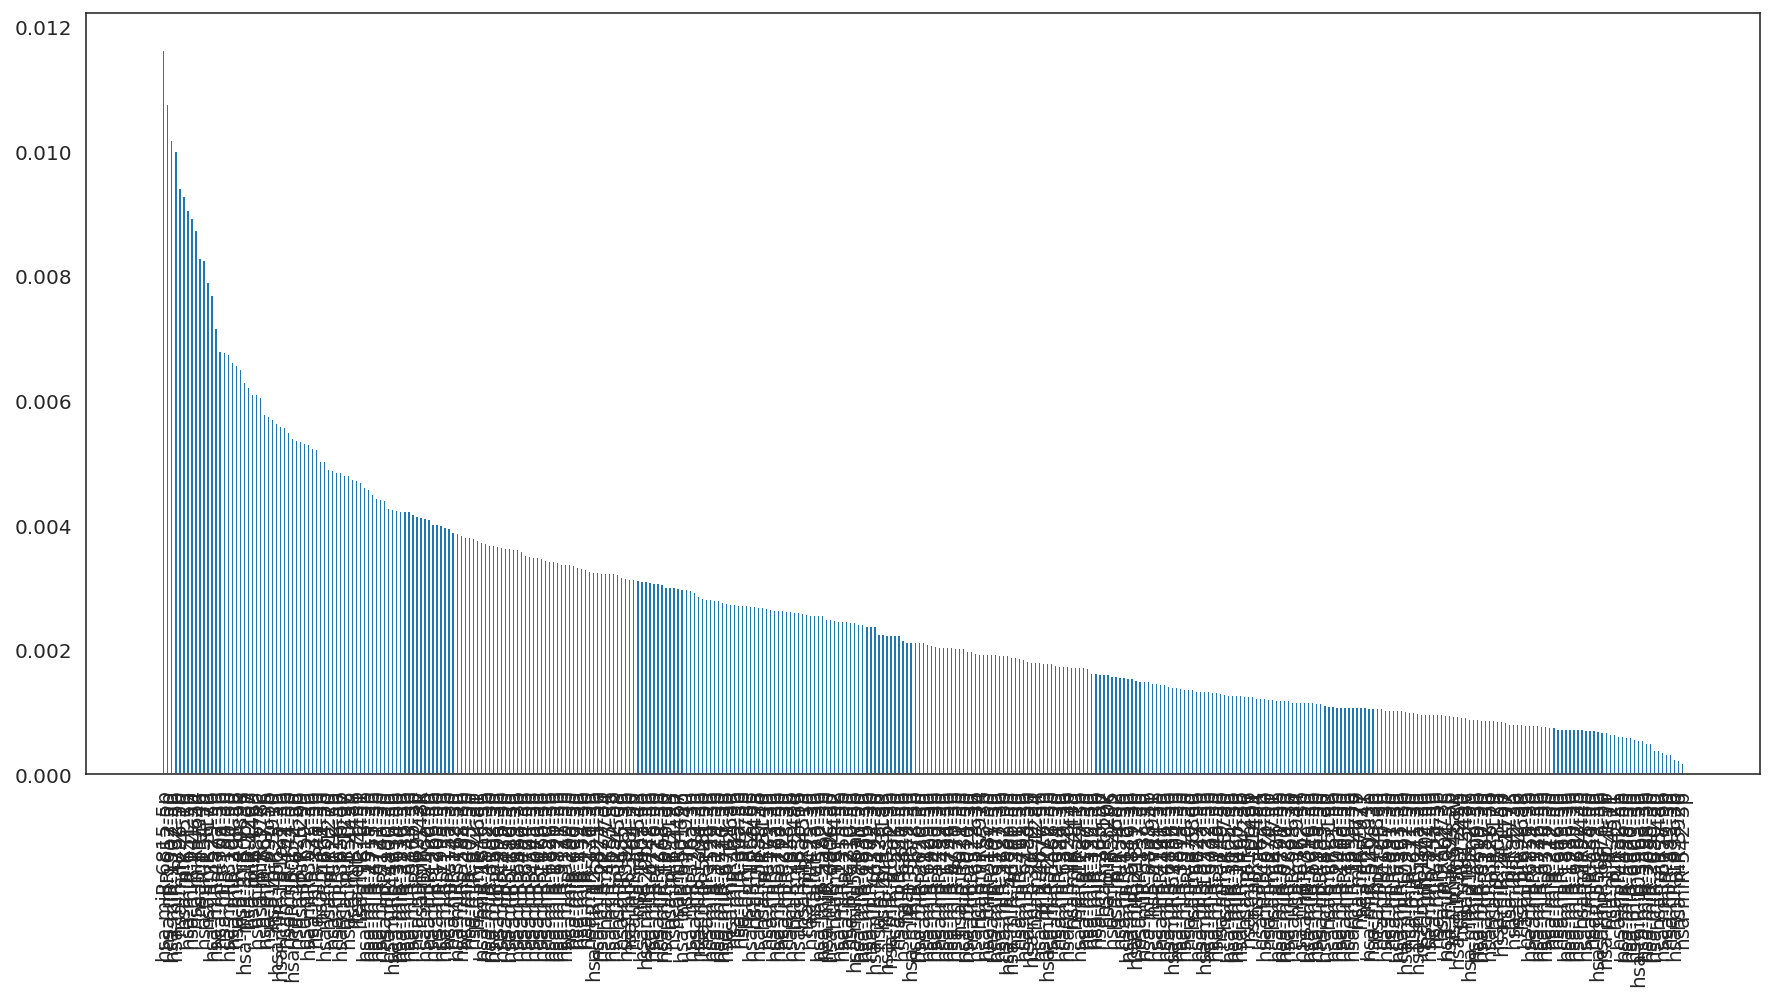

In [ ]:
graph = importance_score[importance_score['Score'] > 0]
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(graph.miRNA, graph.Score)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

# get a list of models to evaluate
def get_models():
	models = dict()
	for i in range(2, 40):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
# X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))


>2 0.840 (0.119)
>3 0.860 (0.116)
>4 0.854 (0.131)
>5 0.857 (0.125)
>6 0.857 (0.121)
>7 0.857 (0.122)
>8 0.851 (0.121)
>9 0.858 (0.127)
>10 0.857 (0.124)
>11 0.858 (0.119)
>12 0.871 (0.125)
>13 0.860 (0.116)
>14 0.851 (0.122)
>15 0.857 (0.121)
>16 0.861 (0.126)
>17 0.857 (0.121)
>18 0.861 (0.118)
>19 0.864 (0.121)
>20 0.854 (0.122)
>21 0.854 (0.119)
>22 0.857 (0.127)
>23 0.850 (0.130)
>24 0.858 (0.129)
>25 0.864 (0.121)
>26 0.864 (0.121)
>27 0.854 (0.130)
>28 0.847 (0.124)
>29 0.848 (0.124)
>30 0.857 (0.121)
>31 0.854 (0.129)
>32 0.861 (0.118)
>33 0.847 (0.130)
>34 0.847 (0.121)
>35 0.855 (0.119)
>36 0.854 (0.127)
>37 0.857 (0.121)
>38 0.847 (0.122)
>39 0.861 (0.124)


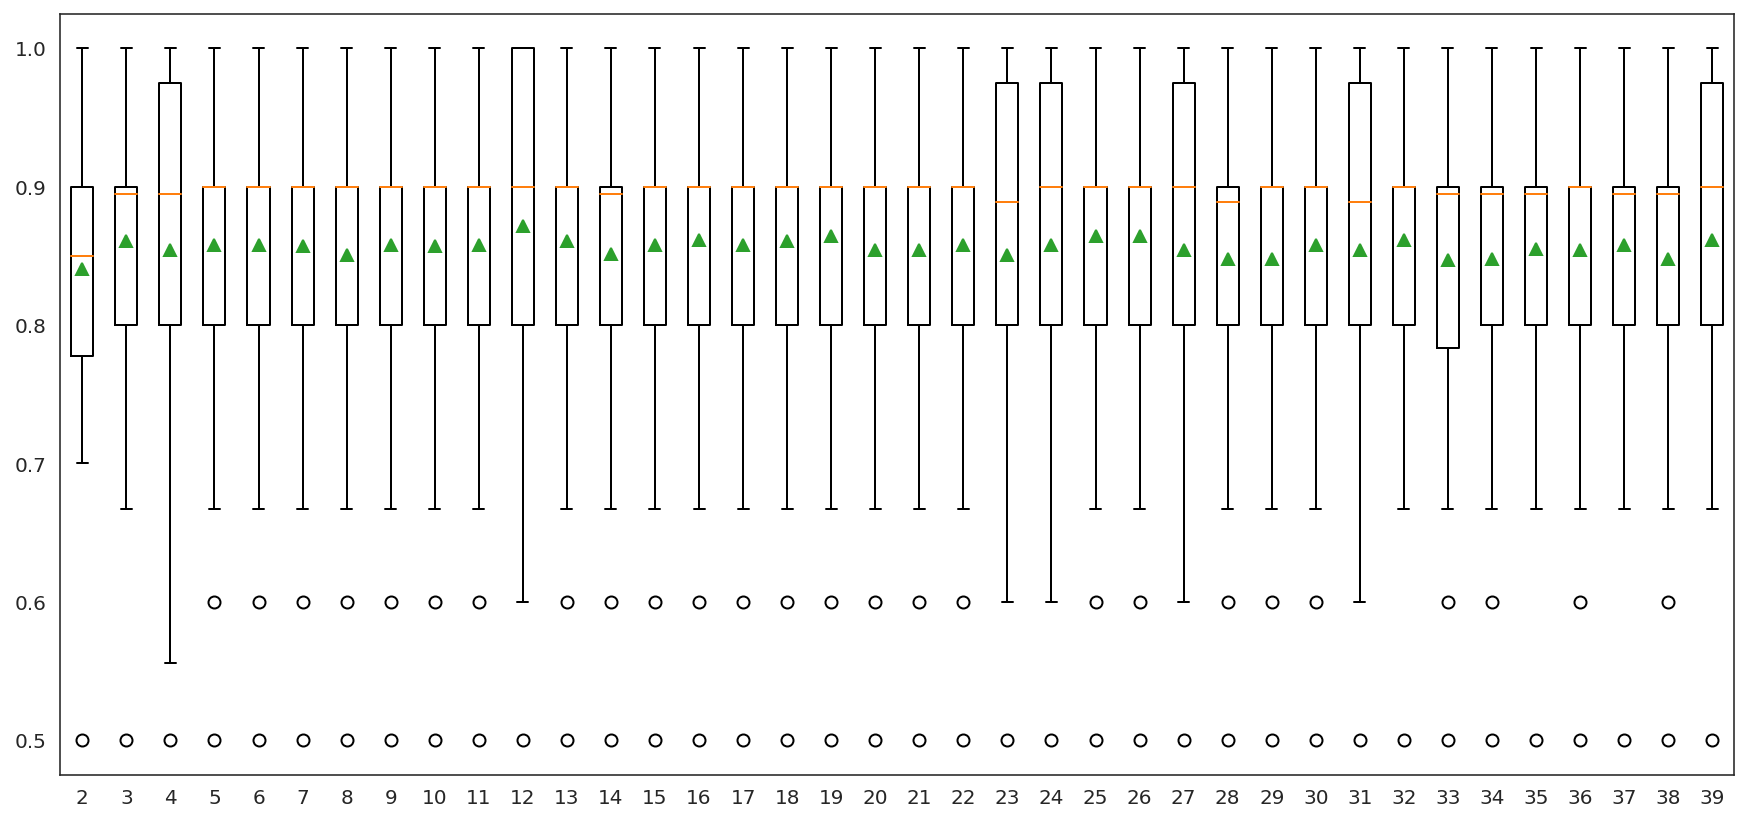

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

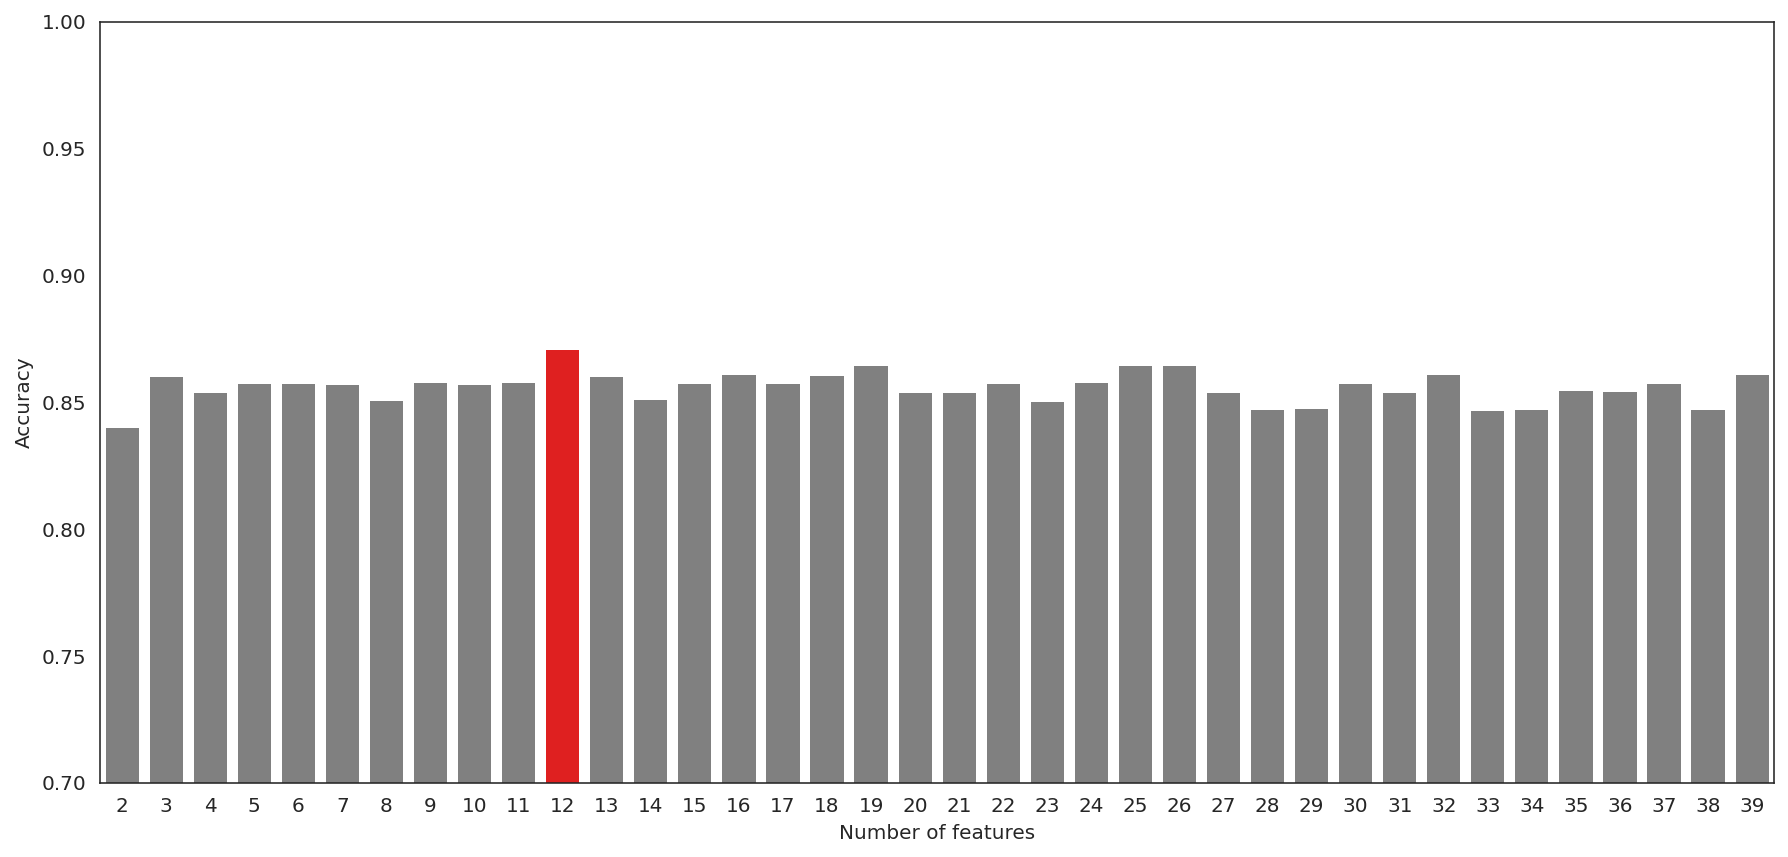

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
values = [np.mean(i) for i in results]
idx =  np.array(range(2,len(values)+2)) 
clrs = ['grey' if (x < max(values)) else 'red' for x in values ]
sns.barplot(x=idx, y=values, palette=clrs) # color=clrs)
plt.xticks(rotation=0)
plt.ylim(0.7,1.0)
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
data_plot = pd.DataFrame([idx,values]).T
data_plot.columns = ['Features','Accuracy']

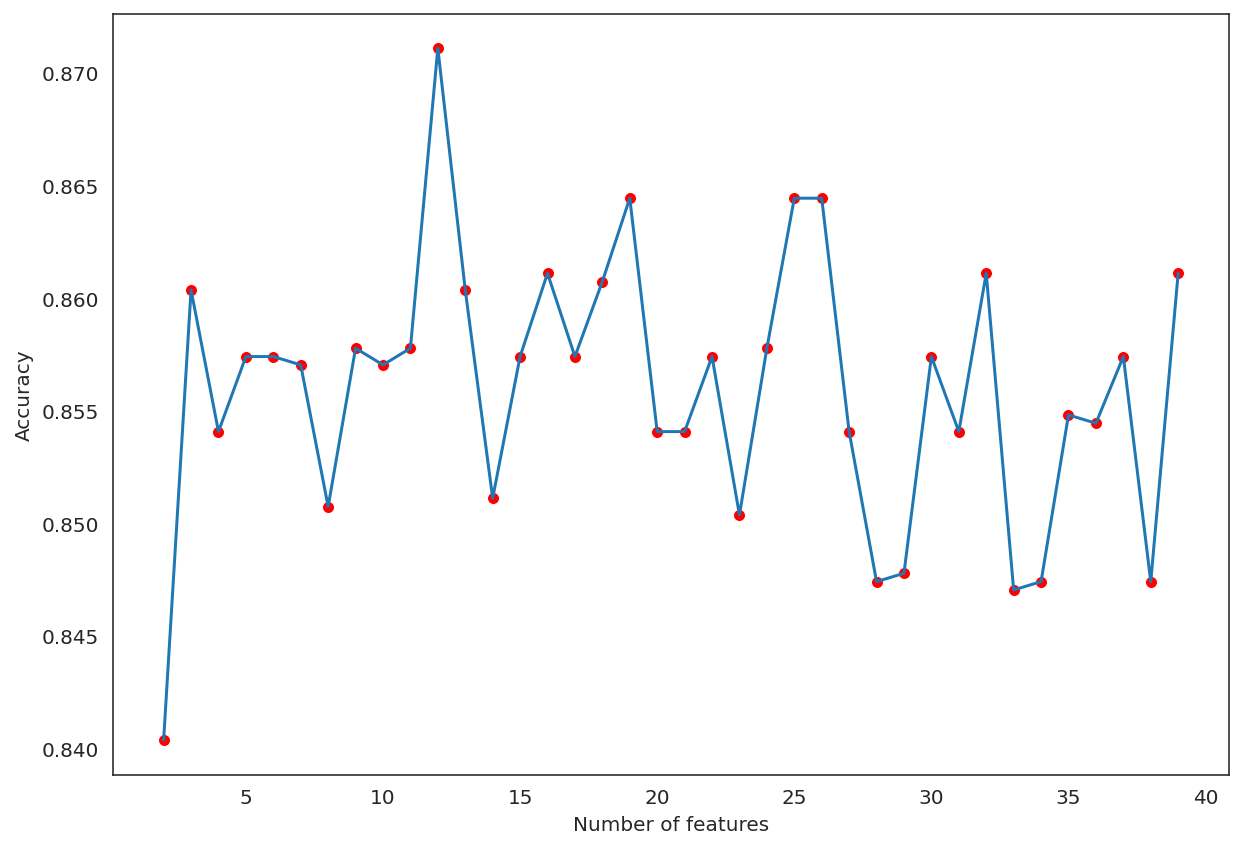

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.lineplot(x='Features', y='Accuracy', data=data_plot)
sns.scatterplot(x='Features', y='Accuracy', data=data_plot, color='Red')
plt.xlabel('Number of features')
plt.show()

In [ ]:
output = base+'Importance feature_tissue_3Groups.csv'
importance_score[importance_score['Score'] > 0].to_csv(output)

In [ ]:
outputs = base+'Data_Importance_tissue_3Groups.csv'
rawData.loc[:, importance_score[importance_score['Score'] > 0]['miRNA'].tolist()].to_csv(outputs)

# Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import homogeneity_score

miRNA = pd.read_excel(base+'miRNA selected from ML1 and Noiseq.xlsx')['miRNAs']
homo = []
for n in range(2,7):
    classDF = rawData.loc[:, miRNA.tolist()]
    kmeans = KMeans(n_clusters=n, random_state=0).fit(classDF)
    classDF['Cluster'] = kmeans.labels_
    classDF['True_class'] = rawData['Class'].tolist()
    h = round(homogeneity_score(classDF['Cluster'], classDF['True_class']),4)
#     print('Homogeneity score', h)
    homo = homo + [[n,h]]
                          
display(pd.DataFrame(homo, columns=['Number of class', 'Homogeneity']))


homo = []
for n in range(2,7):
    classDF = rawData.loc[:, miRNA.tolist()]
    scaled_df = pd.DataFrame(RS.fit_transform(classDF) , columns= classDF.columns, index=classDF.index)
    kmeans = KMeans(n_clusters=n, random_state=0).fit(scaled_df)
    classDF['Cluster'] = kmeans.labels_
    classDF['True_class'] = rawData['Class'].tolist()
    h = round(homogeneity_score(classDF['Cluster'], classDF['True_class']),4)
#     print('Homogeneity score', h)
    homo = homo + [[n,h]]
                          
display(pd.DataFrame(homo, columns=['Number of class', 'Homogeneity']))

,Number of class,Homogeneity
0,2,0.3183
1,3,0.3466
2,4,0.2961
3,5,0.2799
4,6,0.3118


,Number of class,Homogeneity
0,2,0.1456
1,3,0.1262
2,4,0.1318
3,5,0.1244
4,6,0.2011


In [ ]:
n = 3
classDF = rawData.loc[:, miRNA.tolist()]
kmeans = KMeans(n_clusters=n, random_state=0).fit(classDF)
classDF['Cluster'] = kmeans.labels_
classDF['True_class'] = rawData['Class'].tolist()
display(pd.pivot_table(data=classDF, columns='True_class',values='hsa-miR-16-5p', 
               aggfunc='count', index='Cluster', fill_value=0))

True_class,AIS_Discharge,AIS_tissue,HSIL_Discharge,HSIL_tissue,Normal_tissue
Cluster,,,,,
0,4,2,19,11,0
1,0,1,0,23,3
2,0,1,0,6,2


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
homo = []
for n in range(2,7):
    classDF = rawData.loc[:, miRNA.tolist()]
#     scaled_df = pd.DataFrame(RS.fit_transform(classDF) , columns= classDF.columns, index=classDF.index)
    pcaDF = pca.fit_transform(classDF)
    kmeans = KMeans(n_clusters=n, random_state=0).fit(pcaDF)
    classDF['Cluster'] = kmeans.labels_
    classDF['True_class'] = rawData['Class'].tolist()
    h = round(homogeneity_score(classDF['Cluster'], classDF['True_class']),4)
#     print('Homogeneity score', h)
    homo = homo + [[n,h]]
                          
display(pd.DataFrame(homo, columns=['Number of class', 'Homogeneity']))

display(pd.pivot_table(data=classDF, columns='True_class',values='hsa-miR-16-5p', 
               aggfunc='count', index='Cluster', fill_value=0))

,Number of class,Homogeneity
0,2,0.3183
1,3,0.3466
2,4,0.2961
3,5,0.2799
4,6,0.3168


True_class,AIS_Discharge,AIS_tissue,HSIL_Discharge,HSIL_tissue,Normal_tissue
Cluster,,,,,
0,0,0,0,5,1
1,3,2,19,4,0
2,0,1,0,11,1
3,0,0,0,11,1
4,0,1,0,2,2
5,1,0,0,7,0
